[블로그](https://jkisaaclee.kro.kr/keras/facenet/deep%20learning/computer%20vision/2019/10/01/how_to_develop_a_face_recognition_system_using_facenet_in_keras_ko/) 참고한 사진에서 얼굴추출 후 인물 분석하는 코드

In [2]:
# 케라스 FaceNet 모델 로드 예시
from keras.models import load_model
# 모델 불러오기
model = load_model('facenet_keras.h5')
# 입력과 출력 배열 형태 요약
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/Identity:0' shape=(None, 128) dtype=float32>]


In [3]:
# MTCNN이 올바르게 설치되었는지 확인
import mtcnn
# 버전 출력
print(mtcnn.__version__)

0.1.0


1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)


5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)


8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)


13 (160, 160, 3)
14 (160, 160, 3)


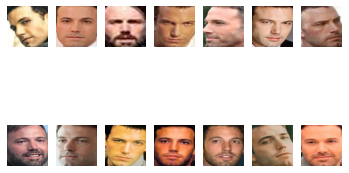

In [11]:
# 5명의 유명인사 얼굴 데이터셋으로 얼굴 감지 표시하기
from os import listdir
from os.path import isdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

# 주어진 사진에서 하나의 얼굴 추출
def extract_face(filename, required_size=(160, 160)):
    # 파일에서 이미지 불러오기
    image = Image.open(filename)
    # RGB로 변환, 필요시
    image = image.convert('RGB')
    # 배열로 변환
    pixels = asarray(image)
    # 감지기 생성, 기본 가중치 이용
    detector = MTCNN()
    # 이미지에서 얼굴 감지
    results = detector.detect_faces(pixels)
    # 첫 번째 얼굴에서 경계 상자 추출
    x1, y1, width, height = results[0]['box'] # boxes -> box로 수정
    # 버그 수정
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # 얼굴 추출
    face = pixels[y1:y2, x1:x2]
    # 모델 사이즈로 픽셀 재조정
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

# 폴더를 플롯으로 구체화하기
folder = '5-celebrity-faces-dataset/train/ben_afflek/'
i = 1
# 파일 열거
for filename in listdir(folder):
    # 경로
    path = folder + filename
    # 얼굴 추출
    face = extract_face(path)
    print(i, face.shape)
    # 플롯
    pyplot.subplot(2, 7, i)
    pyplot.axis('off')
    pyplot.imshow(face)
    i += 1
pyplot.show()

In [12]:
# 디렉토리 안의 모든 이미지를 불러오고 이미지에서 얼굴 추출
def load_faces(directory):
    faces = list()
    # 파일 열거
    for filename in listdir(directory):
        # 경로
        path = directory + filename
        # 얼굴 추출
        face = extract_face(path)
        # 저장
        faces.append(face)
    return faces

In [13]:
# 이미지를 포함하는 각 클래스에 대해 하나의 하위 디렉토리가 포함된 데이터셋을 불러오기
def load_dataset(directory):
    X, y = list(), list()
    # 클래스별로 폴더 열거
    for subdir in listdir(directory):
        # 경로
        path = directory + subdir + '/'
        # 디렉토리에 있을 수 있는 파일을 건너뛰기(디렉토리가 아닌 파일)
        if not isdir(path):
            continue
        # 하위 디렉토리의 모든 얼굴 불러오기
        faces = load_faces(path)
        # 레이블 생성
        labels = [subdir for _ in range(len(faces))]
        # 진행 상황 요약
        print('>%d개의 예제를 불러왔습니다. 클래스명: %s' % (len(faces), subdir))
        # 저장
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [16]:
from numpy import savez_compressed

#훈련 데이터셋 불러오기
trainX, trainy = load_dataset('5-celebrity-faces-dataset/train/')
print(trainX.shape, trainy.shape)
# 테스트 데이터셋 불러오기
testX, testy = load_dataset('5-celebrity-faces-dataset/val/')
print(testX.shape, testy.shape)
# 배열을 단일 압축 포맷 파일로 저장
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>14개의 예제를 불러왔습니다. 클래스명: ben_afflek


>17개의 예제를 불러왔습니다. 클래스명: elton_john


>21개의 예제를 불러왔습니다. 클래스명: jerry_seinfeld


>19개의 예제를 불러왔습니다. 클래스명: madonna


>22개의 예제를 불러왔습니다. 클래스명: mindy_kaling
(93, 160, 160, 3) (93,)


>5개의 예제를 불러왔습니다. 클래스명: ben_afflek


>5개의 예제를 불러왔습니다. 클래스명: elton_john


>5개의 예제를 불러왔습니다. 클래스명: jerry_seinfeld


>5개의 예제를 불러왔습니다. 클래스명: madonna


>5개의 예제를 불러왔습니다. 클래스명: mindy_kaling
(25, 160, 160, 3) (25,)


In [17]:
# facenet을 이용해 데이터셋 내 각 얼굴에 대한 얼굴 임베딩 계산
from numpy import load
from numpy import expand_dims
from numpy import asarray
from keras.models import load_model

# 하나의 얼굴의 얼굴 임베딩 얻기
def get_embedding(model, face_pixels):
    # 픽셀 값의 척도
    face_pixels = face_pixels.astype('int32')
    # 채널 간 픽셀값 표준화(전역에 걸쳐)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # 얼굴을 하나의 샘플로 변환
    samples = expand_dims(face_pixels, axis=0)
    # 임베딩을 갖기 위한 예측 생성
    yhat = model.predict(samples)
    return yhat[0]

# 얼굴 데이터셋 불러오기
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('불러오기: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# facenet 모델 불러오기
model = load_model('facenet_keras.h5')
print('모델 불러오기')
# 훈련 셋에서 각 얼굴을 임베딩으로 변환하기
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# 테스트 셋에서 각 얼굴을 임베딩으로 변환하기
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# 배열을 하나의 압축 포맷 파일로 저장
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

불러오기:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
모델 불러오기
(93, 128)
(25, 128)


예상: mindy_kaling (92.165)
추측: mindy_kaling


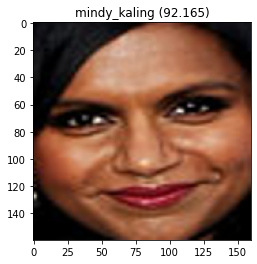

In [19]:
# 5명의 유명인사 얼굴 데이터셋의 분류기 개발
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot

# 얼굴 불러오기
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# 얼굴 임베딩 불러오기
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# 입력 벡터 일반화
in_encoder = Normalizer(norm='l2') # norm값 10->12수정
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# 목표 레이블 암호화
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# 모델 적합
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# 테스트 데이터셋에서 임의의 예제에 대한 테스트 모델
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# 얼굴 예측
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# 이름 얻기
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('예상: %s (%.3f)' % (predict_names[0], class_probability))
print('추측: %s' % random_face_name[0])
# 재미삼아 그리기
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

In [7]:
!pip install cmake
!pip install dlib
!pip install face_recognition

In [6]:
import cv2
import numpy as np
import face_recognition

ModuleNotFoundError: No module named 'face_recognition'